<center> <img src="https://miro.medium.com/v2/resize:fit:1250/format:webp/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width=25% > </center>

<br><br>

<center> 
    <font size="6">Final Lab (Part 1): Keypoint Detection, Bag of Visual Words and Image Classification</font>
</center>
<center> 
    <font size="4">Computer Vision 1 University of Amsterdam</font> 
</center>
<center> 
    <font size="4">Due 23:59PM, October 18, 2024 (Amsterdam time)</font> 
</center>
<center> 
    <font size="4"><b>TA's: Vlad, Matey & Antonios</b></font>
</center>

<br><br>

***

<br><br>

<center>

Student1 ID:  \
Student1 Name: 

Student2 ID: \
Student2 Name: 

Student3 ID: \
Student3 Name: 

( Student4 ID: \
Student4 Name: )

</center>

### **General Guidelines**

Your code must be handed in this Jupyter notebook, renamed to **StudentID1_StudentID2_StudentID3.ipynb** before the deadline by submitting it to the Canvas Final Lab (Part 1) Assignment. Please also fill out your names and IDs above.

For full credit, make sure your notebook follows these guidelines:

- Please express your thoughts **concisely**. The number of words does not necessarily correlate with how well you understand the concepts.
- Understand the problem as much as you can. When answering a question, provide evidence (qualitative and/or quantitative results, references to papers, figures, etc.) to support your arguments. Not everything might be explicitly asked for, so think about what might strengthen your arguments to make the notebook self-contained and complete.
- Tables and figures must be accompanied by a **brief** description. Add a number, a title, and, if applicable, the name and unit of variables in a table, and name and unit of axes and legends in a figure.

**Late submissions are not allowed.** Assignments submitted after the strict deadline will not be graded. In case of submission conflicts, TAs’ system clock is taken as reference. We strongly recommend submitting well in advance to avoid last-minute system failure issues.

**Environment:** Since this is a project-based assignment, you are free to use any feature descriptor and machine learning tools (e.g., K-means, SVM). You should use Python for your implementation. You are free to use any Python library for this assignment, but make sure to provide a conda environment file!

**Plagiarism Note:** Keep in mind that plagiarism (submitted materials which are not your work) is a serious offense and any misconduct will be addressed according to university regulations. This includes using generative tools such as ChatGPT.

**Ensure that you save all results/answers to the questions (even if you reuse some code).**

### **Report Preparation**

Your tasks include the following:

1. **Report Preparation:** For both parts of the final project, students are expected to prepare a report. The report should include all details on implementation approaches, analysis of results for different settings, and visualizations illustrating experiments and performance of your implementation. Grading will be based on the report, so it should be as self-contained as possible. If the report contains faulty results or ambiguities, TAs can refer to your code for clarification. Only section 10 of this notebook should **not** be included in the report.

2. **Explanation of Results:** Do not just provide numbers without explanation. Discuss different settings to show your understanding of the material and processes involved.

3. **Quantitative Evaluation:** For quantitative evaluation, you are expected to provide the results based on the mAP (mean Average Precision) metric. You should report the mAP for each experimental setup. 

4. **Qualitative Evaluation:** For qualitative evaluation, you are expected to visualize the top-5 and bottom-5 ranked test images (based on classifier confidence for the target class) per setup. Provide a figure for each experimental setup Visual elements such as charts, graphs, and plots are always useful. Keep this in mind while writing your reports.

5. **Aim:** Understand the basic Image Classification pipeline using a traditional Bag of Visual Words method.

6. **Working on Assignments:** Students should work in assigned groups for **two** weeks. Any questions can be discussed on ED.

    - **Submission:** Submit your source code and report together in a zip file (`ID1_ID2_ID3_part1.zip`). The report should be a maximum of 10 pages (single-column, including tables and figures, excluding references and appendix). Express thoughts concisely. Tables and figures must be accompanied by a description. Number them and, if applicable, name variables in tables, and label axes in figures.

7. **Hyperparameter Search:** In your experiments, remember to perform a hyperparameter search to find the optimal settings for your classifier. Clearly document the search process, the parameters you explored, and how they influenced the performance of your model.

8. **Format and Testing:** The report should be in **PDF format**, and the code in **.ipynb format**. Test that all functionality works as expected in the notebook.

### **Overview**

- [Section 1: Data Preparation (0 points)](#section-1)
- [Section 2: Keypoint Detection and Feature Extraction (3 points)](#section-2)
- [Section 3: Building the Visual Vocabulary (3 points)](#section-3)
- [Section 4: Encoding Train Image Features (3 points)](#section-4)
- [Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)](#section-5)
- [Section 6: Encoding Test Image Features (0 points)](#section-6)
- [Section 7: Training the Classifiers (5 points)](#section-7)
- [Section 8: Evaluating the Classifiers (12 points)](#section-8)
- [Section 9: Hyperparameter Search (16 points)](#section-9)
- [Section 10: Using CLIP for Image Classification (5 points)](#section-10)
- [Section X: Individual Contribution Report (Mandatory)](#section-x)

### **Section 1: Data Preparation (0 points)**

The goal of this lab is to implement an image classification system that can identify objects from a given set of classes. You will perform a 5-class image classification using a bag-of-words approach ([reference](http://www.robots.ox.ac.uk/~az/icvss08_az_bow.pdf)). The classes for this task are:

1. **Frog**
2. **Automobile**
3. **Bird**
4. **Cat**
5. **Deer**

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) will be used for this task. This dataset contains 32x32 pixel RGB images, divided into sub-directories with 5000 training images and 1000 test images for each class.

The dataset will be automatically downloaded using the code provided in this notebook. You will need to perform training on the training set, which will later be divided into two subsets: one for building the visual vocabulary and another for training the classifier. Using more samples for training generally results in better performance. However, if computational resources are limited, you may use fewer training images to save time, as long as at least 500 images per class are included.

The system must be tested using the specified subset of test images. Use all 1000 test images (per class) to observe the full performance of the model. Ensure that test images are excluded from training to maintain a fair comparison.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [36]:
# Define total train and test sizes
total_train_size = 5000  # Default value for total training images
total_test_size = 1000   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = total_train_size
test_batch_size = total_test_size

# Define the number of Visual Words
num_of_visual_words = 1000  # Default value for number of visual words

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

# Extract all training data and remapped labels
train_images, _ = next(iter(train_data_loader))
train_labels = torch.tensor(train_mapped_labels)

train_images = train_images.permute(0, 2, 3, 1)
print(f"Filtered train data: {train_images.shape}")
print(f"Filtered train labels: {train_labels.shape}")

# Extract all test data and remapped labels
test_images, _ = next(iter(test_data_loader))
test_labels = torch.tensor(test_mapped_labels)

test_images = test_images.permute(0, 2, 3, 1)
print(f"Filtered test data: {test_images.shape}")
print(f"Filtered test labels: {test_labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Filtered train data: torch.Size([5000, 32, 32, 3])
Filtered train labels: torch.Size([5000])
Filtered test data: torch.Size([1000, 32, 32, 3])
Filtered test labels: torch.Size([1000])


<a id="section-2"></a>
### **Section 2: Keypoint Detection and Feature Extraction (3 points)**

In this section, you will work on detecting keypoints and extracting features from the dataset. Your task is to use **two different feature extraction techniques** to identify keypoints in the images. Visualize two images from each of the five classes (Frog, Automobile, Bird, Cat, Deer) for both feature extraction techniques. For each image, draw circles around the detected keypoints that represent their size.

This step is essential to understand how different feature extractors behave across various classes, setting the foundation for further analysis and classification in later steps.

**Hint:** You can use the OpenCV library to detect keypoints and extract features. You can also upscale the images to improve the visualization of the keypoints.

#### Visualise the labels from the training set

In [3]:
label_mapping = {0: "Frog", 1: "Automobile", 2: "Bird", 3: "Cat", 4: "Deer"}

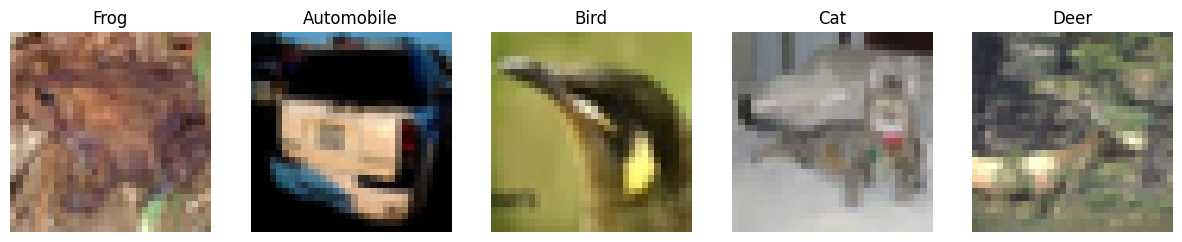

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Extract unique labels
unique_labels = torch.unique(train_labels)

# Plot example images for each unique label
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))

for i, label in enumerate(unique_labels):
    # Find indices of images with the current label
    indices = (train_labels == label).nonzero(as_tuple=True)[0]
    # Randomly select one index
    idx = np.random.choice(indices)
    # Extract the image
    image = train_images[idx].numpy()  
    # Normalize the image
    image = (image * 0.5) + 0.5  

    # Plot the image
    axes[i].imshow(image)
    axes[i].set_title(f"{label_mapping[label.item()]}")
    axes[i].axis('off')

plt.show()

Label 0: Frog 
Label 1: Automobile
Label 2: Bird
Label 3: Cat
Label 4: Deer

#### Create a function to extract keypoints and descriptors

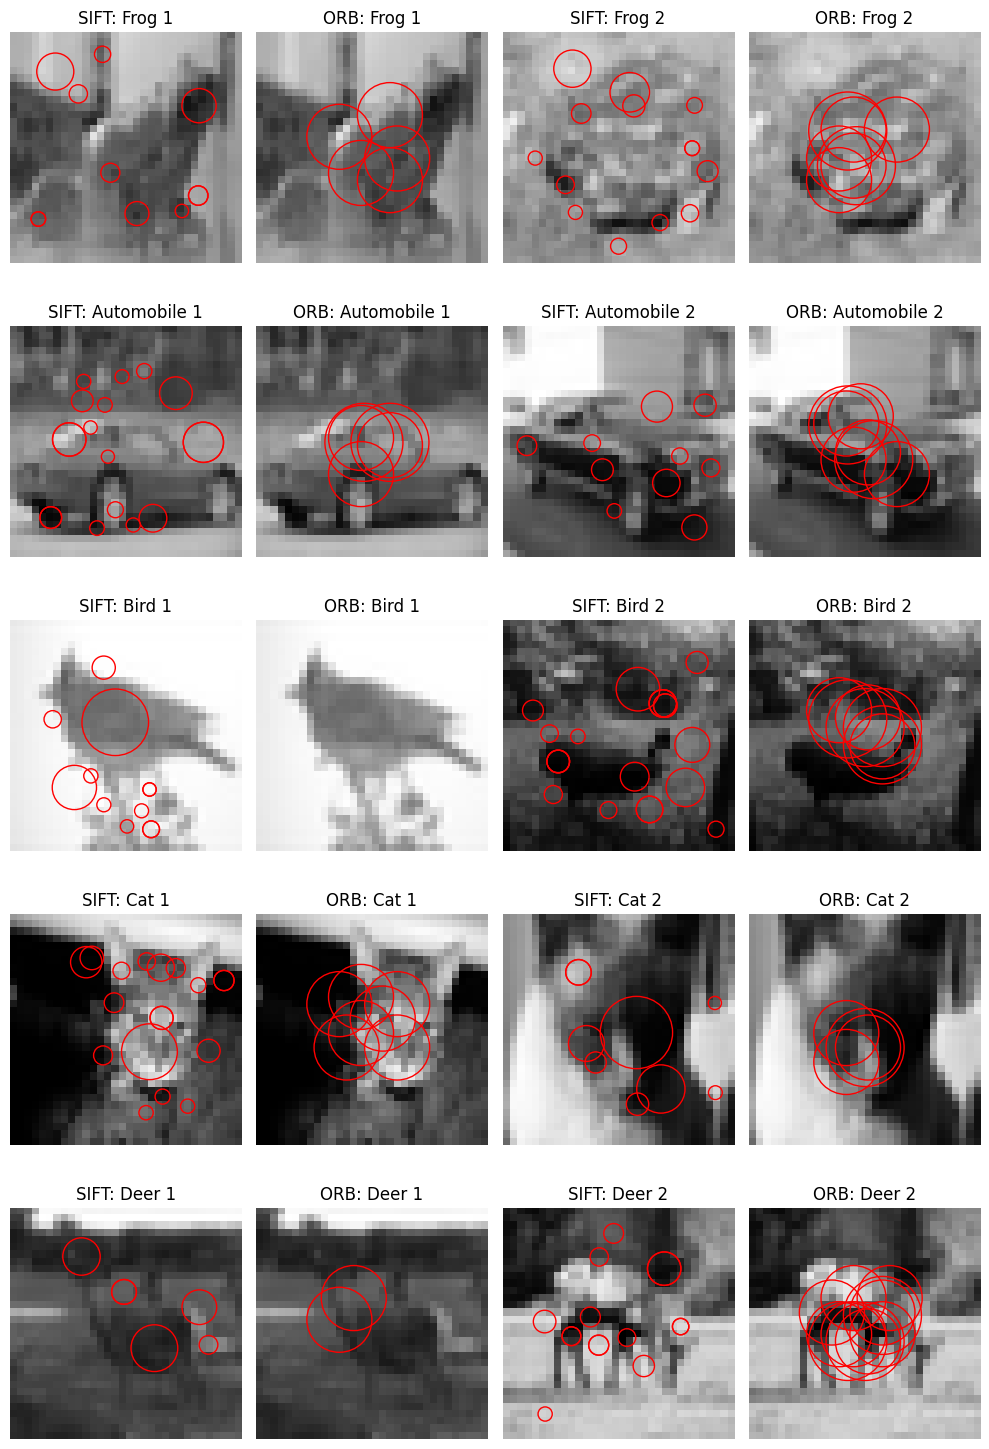

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def normalize_upscale(image: np.ndarray) -> np.ndarray:
    """
    Normalize and upscale the image to 0-255 range.
    """
    image = (image * 0.5) + 0.5 # Normalize to [0, 1]
    image = (image * 255).astype(np.uint8)  # Upscale to [0, 255]
    #image = cv2.resize(image, (128, 128))  # Resize to 128x128
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    return image

def visualize_keypoints(image, keypoints, ax, title):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for kp in keypoints:
        ax.add_patch(plt.Circle((kp.pt[0], kp.pt[1]), kp.size/2, color='r', fill=False))
    ax.imshow(image_rgb)
    ax.set_title(title)
    ax.axis('off')

def detect_and_visualize_keypoints(images, labels, sift, orb, axes):
    unique_labels = torch.unique(labels)
    for i, label in enumerate(unique_labels):
        indices = (labels == label).nonzero(as_tuple=True)[0]
        selected_indices = np.random.choice(indices, 2, replace=False)
        for j, idx in enumerate(selected_indices):
            image = images[idx].numpy()
            image = normalize_upscale(image)

            # SIFT keypoints
            sift_keypoints, _ = sift.detectAndCompute(image, None)
            visualize_keypoints(image, sift_keypoints, axes[i, j*2], f"SIFT: {label_mapping[label.item()]} {j+1}")

            # ORB keypoints
            orb_keypoints, _ = orb.detectAndCompute(image, None)
            visualize_keypoints(image, orb_keypoints, axes[i, j*2 + 1], f"ORB: {label_mapping[label.item()]} {j+1}")

# Example usage
sift = cv2.SIFT_create()
orb = cv2.ORB_create(edgeThreshold=11, patchSize=9)

# Assuming train_images and train_labels are already defined
fig, axes = plt.subplots(5, 4, figsize=(10, 15))

detect_and_visualize_keypoints(train_images, train_labels, sift, orb, axes)
plt.tight_layout()
plt.show()

#### View number of detected keypoints per class per method

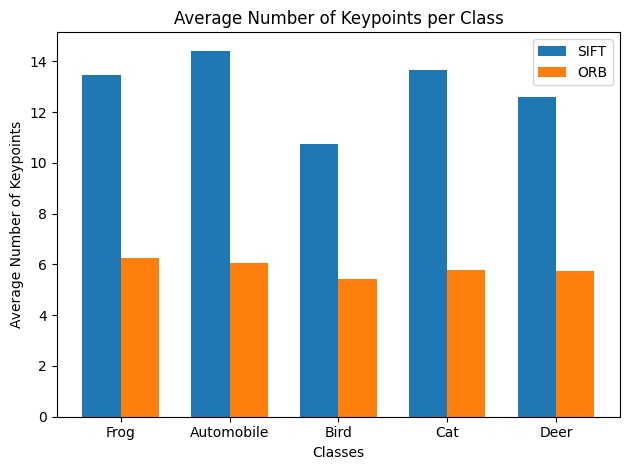

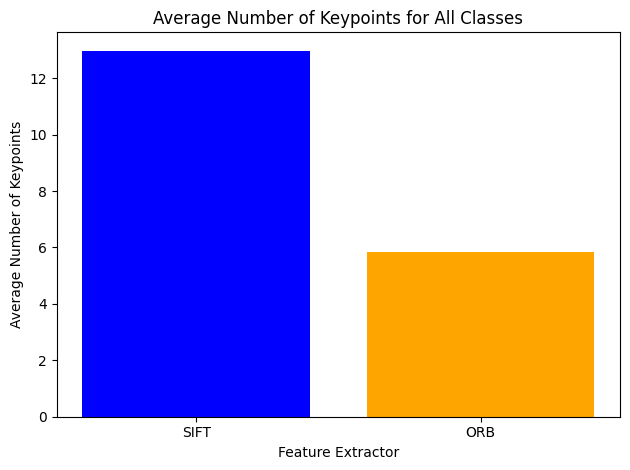

In [6]:
def calculate_keypoints_per_class(images, labels, sift, orb):
    """
    Get the total number of keypoints per class and the total class counts
    
    :param images: 
    :param labels: 
    :param sift: 
    :param orb: 
    :return: 
    """
    unique_labels = torch.unique(labels)
    sift_keypoints_count = {label.item(): 0 for label in unique_labels}
    orb_keypoints_count = {label.item(): 0 for label in unique_labels}
    class_counts = {label.item(): 0 for label in unique_labels}

    for idx, label in enumerate(labels):
        image = images[idx].numpy()
        image = normalize_upscale(image)

        # SIFT keypoints
        sift_keypoints, _ = sift.detectAndCompute(image, None)
        sift_keypoints_count[label.item()] += len(sift_keypoints)

        # ORB keypoints
        orb_keypoints, _ = orb.detectAndCompute(image, None)
        orb_keypoints_count[label.item()] += len(orb_keypoints)

        class_counts[label.item()] += 1

    return sift_keypoints_count, orb_keypoints_count, class_counts

def plot_keypoints_per_class(sift_keypoints_count, orb_keypoints_count, class_counts, label_mapping):
    """
    Plot the keypoint counts per detector
    
    :param sift_keypoints_count: 
    :param orb_keypoints_count: 
    :param class_counts: 
    :param label_mapping: 
    :return: 
    """
    classes = list(label_mapping.values())
    sift_counts = [sift_keypoints_count[label] / class_counts[label] for label in class_counts]
    orb_counts = [orb_keypoints_count[label] / class_counts[label] for label in class_counts]

    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, sift_counts, width, label='SIFT')
    rects2 = ax.bar(x + width/2, orb_counts, width, label='ORB')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Average Number of Keypoints')
    ax.set_title('Average Number of Keypoints per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    fig.tight_layout()
    plt.show()

def plot_average_keypoints(sift_keypoints_count, orb_keypoints_count, class_counts):
    total_sift_keypoints = sum(sift_keypoints_count.values())
    total_orb_keypoints = sum(orb_keypoints_count.values())
    total_images = sum(class_counts.values())

    avg_sift_keypoints = total_sift_keypoints / total_images
    avg_orb_keypoints = total_orb_keypoints / total_images

    labels = ['SIFT', 'ORB']
    avg_counts = [avg_sift_keypoints, avg_orb_keypoints]

    fig, ax = plt.subplots()
    ax.bar(labels, avg_counts, color=['blue', 'orange'])

    ax.set_xlabel('Feature Extractor')
    ax.set_ylabel('Average Number of Keypoints')
    ax.set_title('Average Number of Keypoints for All Classes')

    fig.tight_layout()
    plt.show()

# Get keypoint counts
sift_keypoints_count, orb_keypoints_count, class_counts = calculate_keypoints_per_class(train_images, train_labels, sift, orb)

# Assuming label_mapping is already defined
plot_keypoints_per_class(sift_keypoints_count, orb_keypoints_count, class_counts, label_mapping)
plot_average_keypoints(sift_keypoints_count, orb_keypoints_count, class_counts)

<a id="section-3"></a>
### **Section 3: Building the Visual Vocabulary (3 points)**

In this section, the task is to create a visual vocabulary by clustering feature descriptors extracted from the images using K-Means. Each cluster center in this vocabulary will represent a visual word. Use the two different extraction techniques you implemented to extract descriptors from a subset of training images that includes all categories, and then apply K-Means clustering to build the vocabulary. The number of clusters is fixed at 1000, but you can experiment with different values when you are tuning the hyperparameters in section 9.

To examine the effect of different amounts of training data, build separate visual vocabularies using 30%, 40%, and 50% subsets of the training images. For faster clustering, the `faiss` library can be used, as it provides an efficient implementation of K-Means. Then, visualize the first 10 clusters for each feature extraction technique and each subset size using PCA to reduce the dimensions to 2D.

**Hints:**
1. Begin by debugging the code with a small number of input images to ensure it functions correctly before running it on larger datasets.
2. If the `faiss` library is not available, K-Means clustering can also be performed using the `sklearn` or `scipy` libraries.
3. For visualization, use PCA from `sklearn.decomposition` to reduce the high-dimensional descriptors to 2D. Display up to 10 clusters in the scatter plot to maintain clarity.

Building visual vocabulary for subset ratio: 0.3
Selected 1500 images out of 5000 for descriptor extraction


/Users/cisaicu/miniconda3/envs/cv1_final1/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Explained variance ratio for SIFT 30.0%: 17.31%
Selected 1500 images out of 5000 for descriptor extraction
Explained variance ratio for ORB 30.0%: 34.54%
Building visual vocabulary for subset ratio: 0.4
Selected 2000 images out of 5000 for descriptor extraction
Explained variance ratio for SIFT 40.0%: 17.25%
Selected 2000 images out of 5000 for descriptor extraction
Explained variance ratio for ORB 40.0%: 34.31%
Building visual vocabulary for subset ratio: 0.5
Selected 2500 images out of 5000 for descriptor extraction
Explained variance ratio for SIFT 50.0%: 17.26%
Selected 2500 images out of 5000 for descriptor extraction
Explained variance ratio for ORB 50.0%: 34.43%


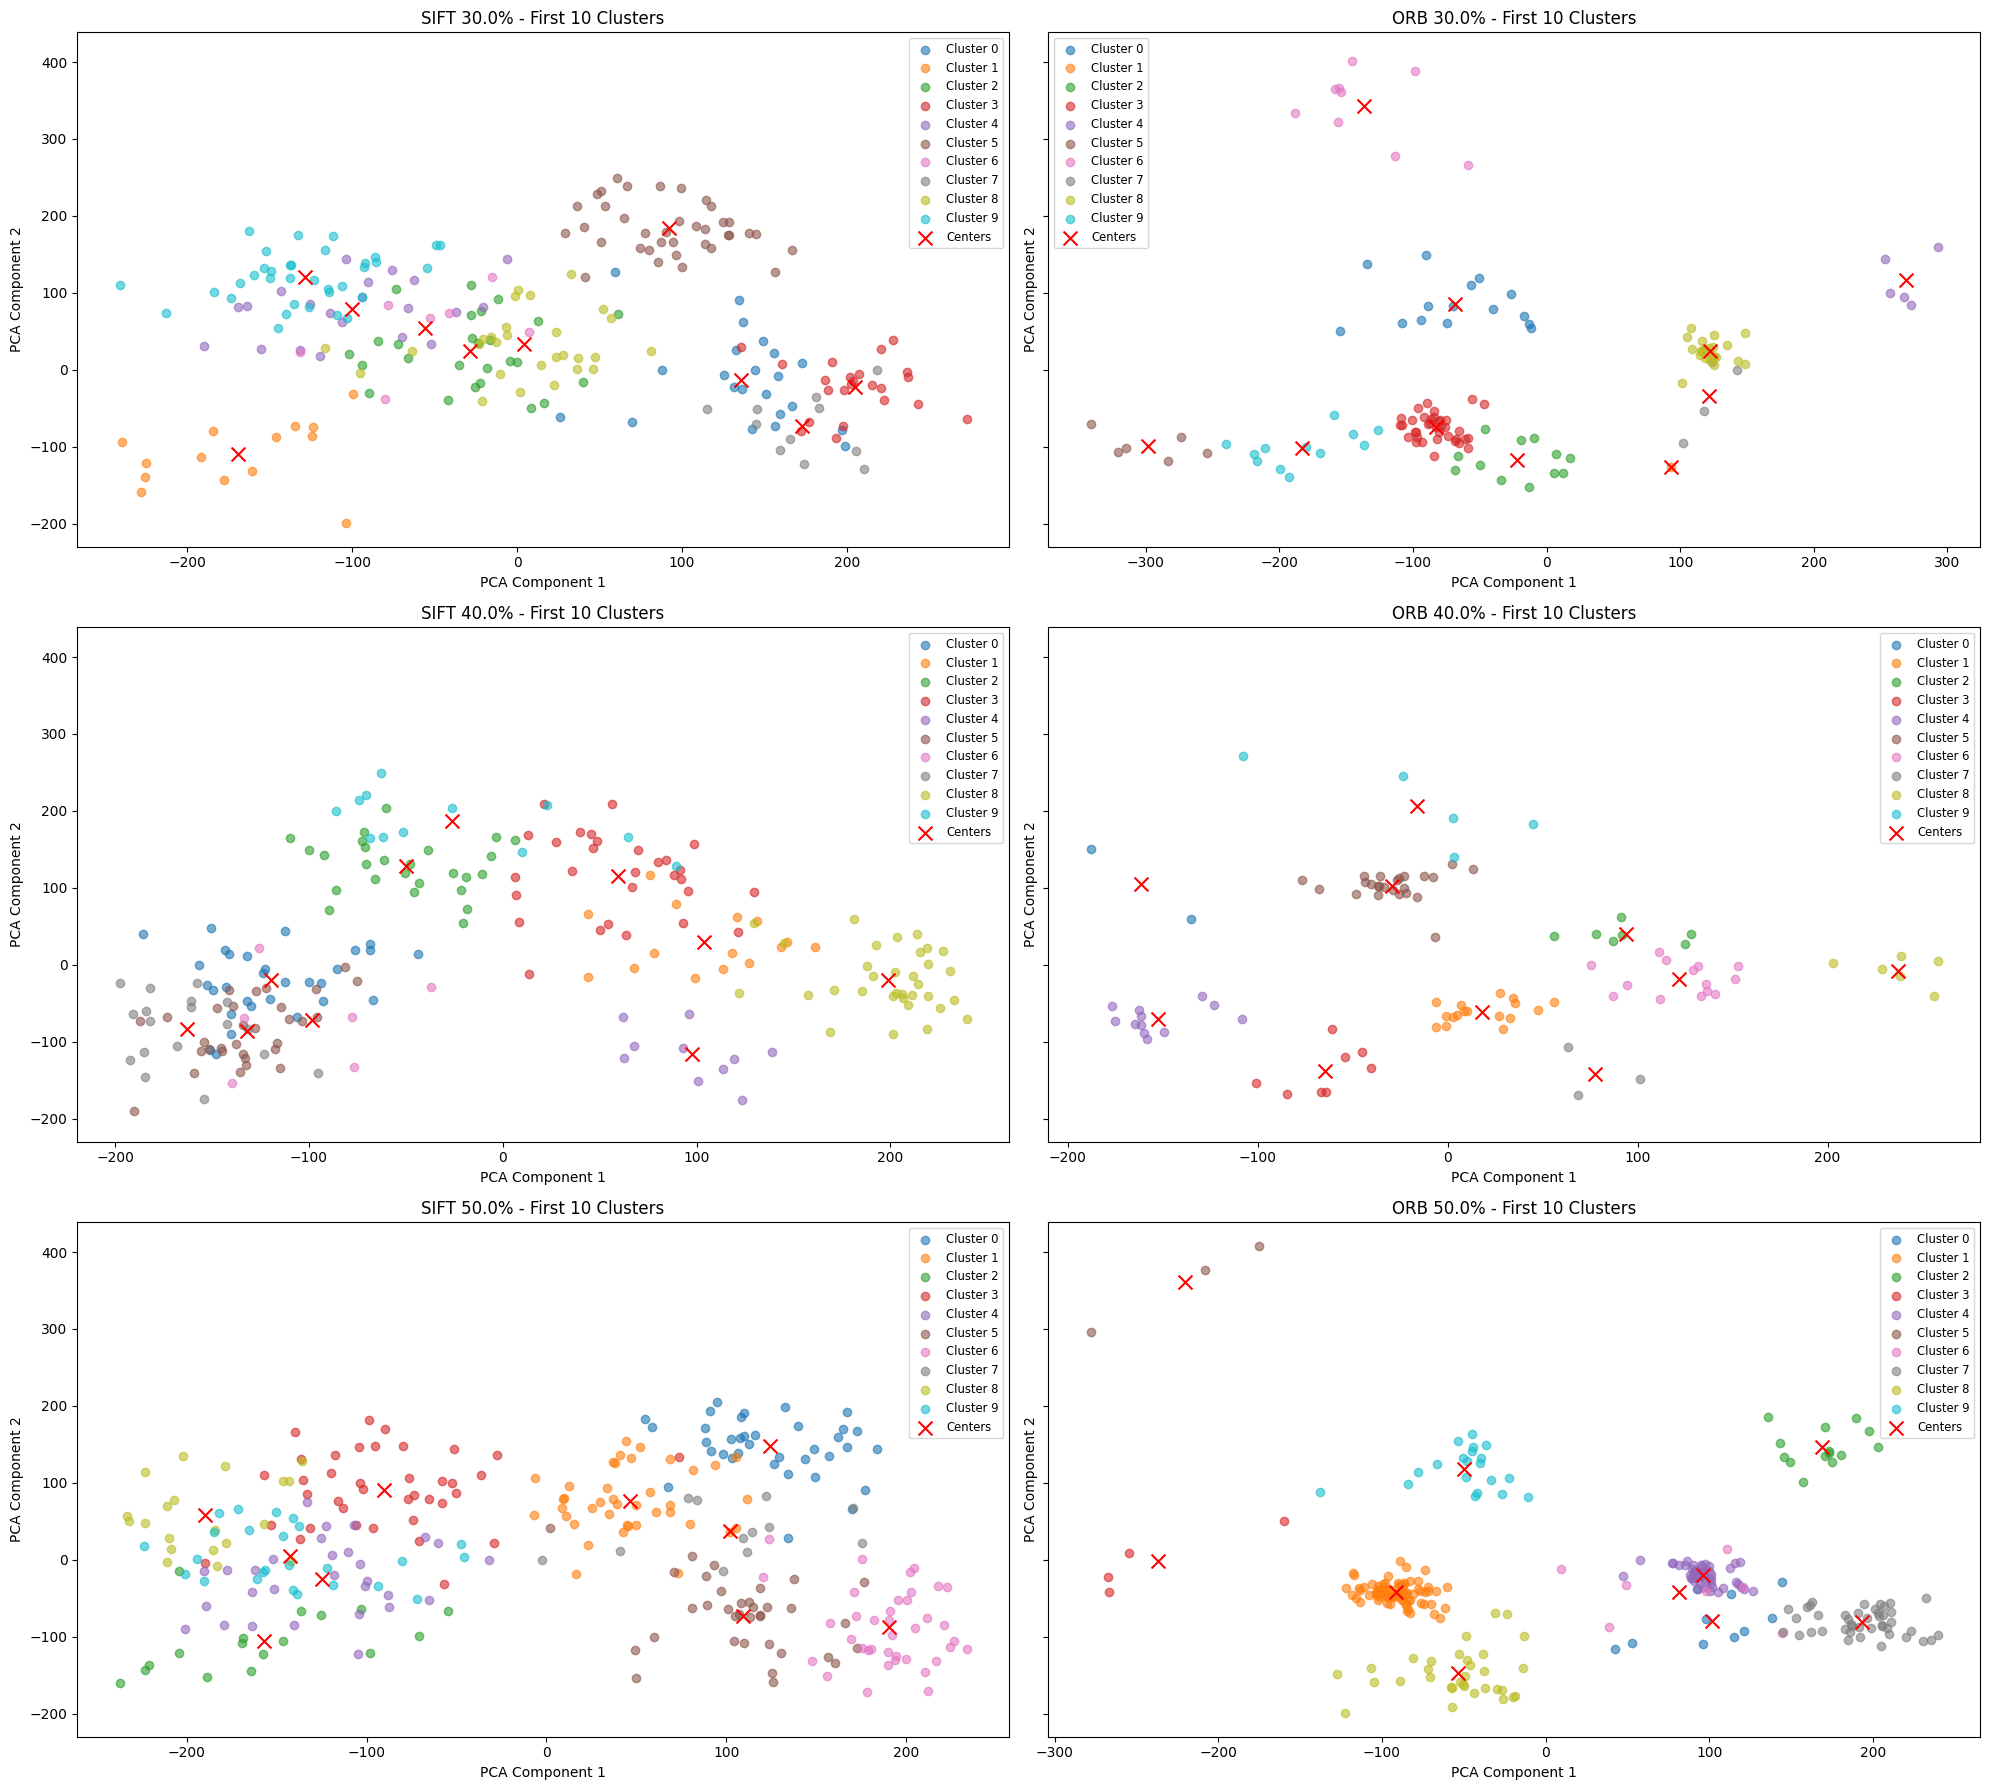

In [8]:
import faiss
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
import matplotlib.pyplot as plt
import numpy as np

def extract_descriptors(images, labels, feature_extractor, subset_ratio):
    """
    Extract feature descriptors from a subset of training images.
    :param images: Input images (e.g., train_images)
    :param labels: Corresponding labels for the images
    :param feature_extractor: Feature extractor (e.g., SIFT or ORB)
    :param subset_ratio: Percentage of total images to use (e.g., 0.3 for 30%)
    :return: Combined descriptors for the selected images
    """
    num_images = len(images)
    subset_size = int(num_images * subset_ratio)  # Calculate how many images to select
    
    # Randomly select the indices for the images
    selected_indices = random.sample(range(num_images), subset_size)
    print(f"Selected {subset_size} images out of {num_images} for descriptor extraction")
    
    descriptors_list = []

    for idx in selected_indices:
        image = images[idx].numpy()
        image = normalize_upscale(image)
        
        keypoints, descriptors = feature_extractor.detectAndCompute(image, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    
    if descriptors_list:
        return np.vstack(descriptors_list)
    else:
        return None

def build_visual_vocabulary(descriptors, num_clusters=1000):
    """
    Build a visual vocabulary using KMeans clustering with 1000 clusters.
    :param descriptors: 
    :param num_clusters: 
    :return: 
    """
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, verbose=0).fit(descriptors)
    return kmeans


def visualize_clusters(kmeans, descriptors, num_clusters=10, title_prefix='SIFT', ax=None):
    """
    Visualize the first 10 clusters using PCA.
    :param kmeans: Fitted KMeans model
    :param descriptors: The descriptors that were clustered
    :param num_clusters: Number of clusters to display (default is 10)
    :param title_prefix: Title prefix for the plot
    :param ax: Matplotlib axis to plot on
    :return: None
    """
    # Reduce the dimensionality of the descriptors using PCA for visualization
    pca = PCA(n_components=2)
    reduced_descriptors = pca.fit_transform(descriptors)

    # Print the explained variance ratio
    variance = sum(pca.explained_variance_ratio_)
    # Show it as a percentage
    print(f"Explained variance ratio for {title_prefix}: {variance*100:.2f}%")
    
    # Get the cluster labels assigned by KMeans
    cluster_labels = kmeans.predict(descriptors)

    # Assign a color for each cluster using the updated colormap method
    colors = plt.get_cmap('tab10', num_clusters)

    # Plot the points with their corresponding cluster labels
    for cluster_id in range(num_clusters):
        cluster_points = reduced_descriptors[cluster_labels == cluster_id]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors(cluster_id)], label=f'Cluster {cluster_id}', alpha=0.6)

    # Reduce the cluster centers using PCA for visualization
    reduced_centers = pca.transform(kmeans.cluster_centers_[:num_clusters])
    ax.scatter(reduced_centers[:, 0], reduced_centers[:, 1], c='r', marker='x', s=100, label='Centers')

    # Set plot title and labels
    ax.set_title(f'{title_prefix.upper()} - First {num_clusters} Clusters')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend(loc='best', fontsize='small')


subset_ratios = [0.3, 0.4, 0.5]
fig, axes = plt.subplots(3, 2, figsize=(20, 18), sharey=True)

for row, ratio in enumerate(subset_ratios):
    print(f"Building visual vocabulary for subset ratio: {ratio}")

    # Extract descriptors using SIFT
    sift_descriptors = extract_descriptors(train_images, train_labels, sift, ratio)
    if sift_descriptors is not None:
        # Perform KMeans clustering first
        sift_kmeans = build_visual_vocabulary(sift_descriptors)
        
        # Visualize clusters after applying PCA
        visualize_clusters(sift_kmeans, sift_descriptors,num_clusters=10, title_prefix=f'SIFT {ratio*100}%', ax=axes[row, 0])
    else:
        print(f"No descriptors found for SIFT with subset ratio: {ratio}")

    # Extract descriptors using ORB
    orb_descriptors = extract_descriptors(train_images, train_labels, orb, ratio)
    if orb_descriptors is not None:
        # Perform KMeans clustering first
        orb_kmeans = build_visual_vocabulary(orb_descriptors)
        
        # Visualize clusters after applying PCA
        visualize_clusters(orb_kmeans, orb_descriptors, num_clusters=10, title_prefix=f'ORB {ratio*100}%', ax=axes[row, 1])
    else:
        print(f"No descriptors found for ORB with subset ratio: {ratio}")

plt.tight_layout()
plt.show()

<a id="section-4"></a>
### **Section 4: Encoding Train Image Features (3 points)**

In this section, the task is to encode image features using the visual vocabulary created earlier. Each image will be represented as a histogram of visual words, reflecting the frequency of each visual word in the image. This representation will allow for comparing images based on their visual content.

To encode an image, identify the nearest visual word (cluster center) for each feature descriptor extracted from the image. Construct a histogram that counts the occurrences of each visual word within the image. The final output will be a collection of histograms, one for each image, where each histogram serves as the feature representation of that image. Once again,  Use the two different extraction techniques you implemented to extract descriptors from the images. Then, encode the images using the visual vocabulary created in the previous step.

**Hint:** Utilize the `faiss` library for efficient nearest neighbor search when assigning each descriptor to the nearest cluster center in the visual dictionary. If `faiss` is not available, consider using other libraries, such as `scikit-learn`, for this step. Once the histograms are obtained, they will be used for further tasks, such as training a classifier. For now, perform the encoding only for the training set.

Random image index: 4072


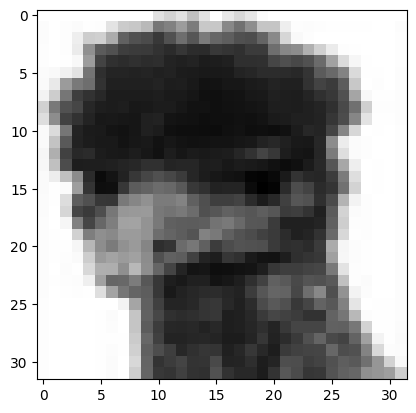

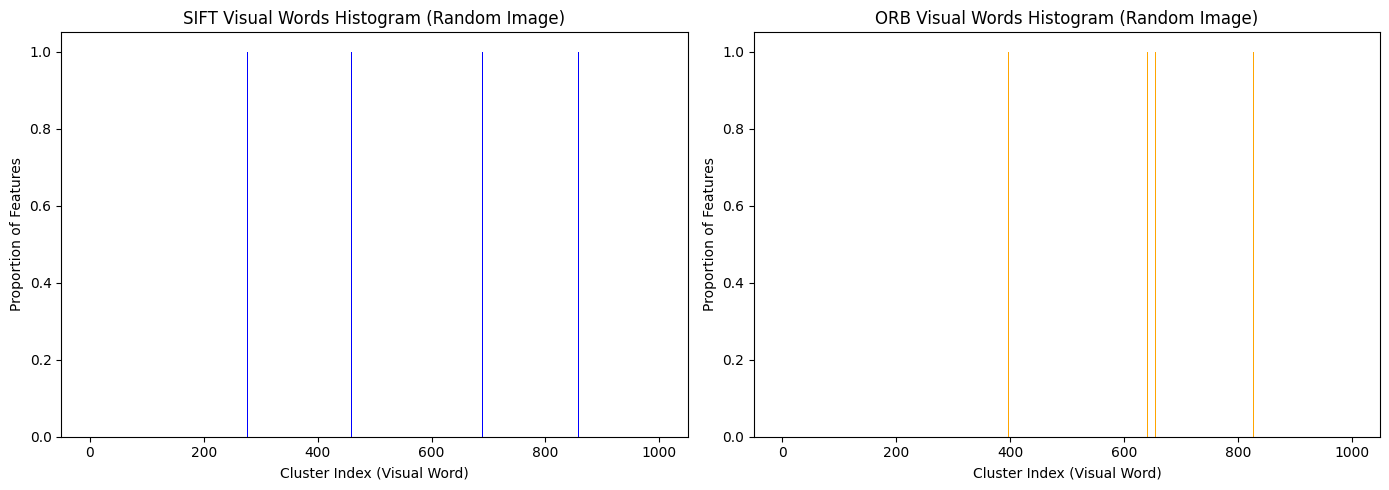

In [9]:
import faiss
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
import cv2
import matplotlib.pyplot as plt

def encode_image_features(images, feature_extractor, num_clusters=1000, subset_ratio=0.5, normalize_histogram=False):
    """
    Encode image features using the visual vocabulary created with KMeans
    :param images: List of images to encode
    :param feature_extractor: Feature extractor (e.g., SIFT, ORB)
    :param num_clusters: Number of clusters (default is 1000)
    :param subset_ratio: Ratio of images to use for training KMeans (default is 0.5)
    :return: Normalized histograms of visual words for each image
    """
    # Step 1: Extract descriptors from the images
    descriptors = []
    for image in images:
        image = image.numpy()
        image = normalize_upscale(image)

        keypoints, desc = feature_extractor.detectAndCompute(image, None)
        if desc is not None:
            descriptors.append(desc)

    if len(descriptors) == 0:
        raise ValueError("No descriptors were extracted from the images.")

    # Combine descriptors from all images
    descriptors = np.vstack(descriptors)

    # Step 2: Apply PCA to reduce dimensionality
    pca = PCA(n_components=2)
    reduced_descriptors = pca.fit_transform(descriptors)

    # Step 3: Train KMeans with reduced descriptors
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, verbose=0).fit(reduced_descriptors)

    # Step 4: Encode the images using the trained KMeans
    image_histograms = []
    for image in images:
        image = image.numpy()
        image = (image * 0.5) + 0.5  # Normalize to [0,1]
        image = (image * 255).astype(np.uint8)  # Scale to [0,255]
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale

        keypoints, descriptors = feature_extractor.detectAndCompute(image, None)

        if descriptors is not None and len(descriptors) >= 2:
            # Use the trained PCA model to reduce the dimensionality of descriptors
            reduced_descriptors = pca.transform(descriptors.astype('float32'))

            # Assign each reduced descriptor to the nearest cluster center
            indices = kmeans.predict(reduced_descriptors)

            # Generate a histogram counting how many features were assigned to each cluster (visual word)
            histogram, _ = np.histogram(indices, bins=np.arange(num_clusters + 1))
            image_histograms.append(histogram)
        else:
            # If no descriptors or too few, add an empty histogram for this image
            image_histograms.append(np.zeros(num_clusters))

    # Normalize the histograms across all images
    image_histograms = np.array(image_histograms)
    if normalize_histogram:
        image_histograms = normalize(image_histograms)
    return image_histograms

# Visualize the histograms for SIFT and ORB in a 1x2 plot
def plot_histograms_side_by_side(sift_histogram, orb_histogram):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Create a 1x2 subplot

    # Plot SIFT histogram
    axes[0].bar(range(len(sift_histogram)), sift_histogram, color='blue')
    axes[0].set_title('SIFT Visual Words Histogram (Random Image)')
    axes[0].set_xlabel('Cluster Index (Visual Word)')
    axes[0].set_ylabel('Proportion of Features')

    # Plot ORB histogram
    axes[1].bar(range(len(orb_histogram)), orb_histogram, color='orange')
    axes[1].set_title('ORB Visual Words Histogram (Random Image)')
    axes[1].set_xlabel('Cluster Index (Visual Word)')
    axes[1].set_ylabel('Proportion of Features')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Encode the training images using the visual vocabulary for SIFT and ORB
sift_encoded_features = encode_image_features(train_images, sift)
orb_encoded_features = encode_image_features(train_images, orb)

# Select a random image index
random_idx = np.random.randint(len(sift_encoded_features))
print(f"Random image index: {random_idx}")
plt.imshow(normalize_upscale(train_images[random_idx].numpy()), cmap='gray')

# Plot the histograms side by side for SIFT and ORB
plot_histograms_side_by_side(sift_encoded_features[random_idx], orb_encoded_features[random_idx])

<a id="section-5"></a>
### **Section 5: Visualizing the Bag of Visual Words for Each Class (3 points)**

In this section, the task is to visualize the Bag of Visual Words for each class using the histograms generated in the previous step. The goal is to plot the mean histogram of visual words for each class, showing the distribution of visual words across the different categories in the training set.

Use the two different extraction techniques you implemented for this visualization. For each technique, calculate the mean histogram for each class and create a bar plot to display these histograms. Ensure that the plots are labeled clearly with the class names and feature descriptor types.

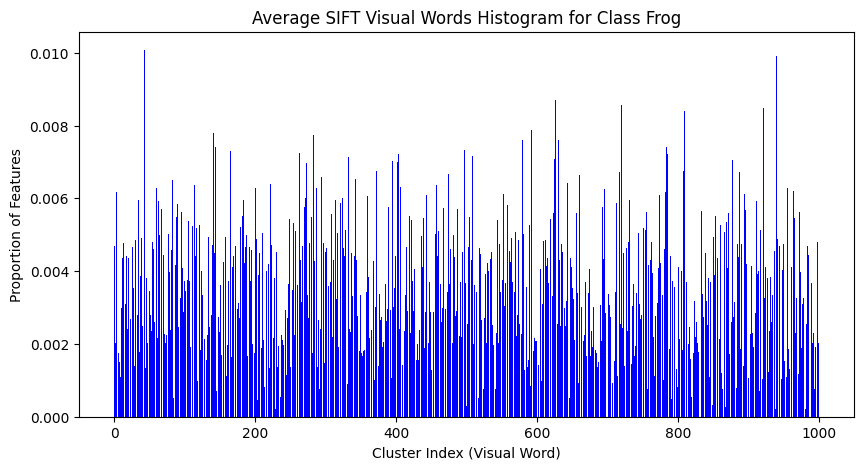

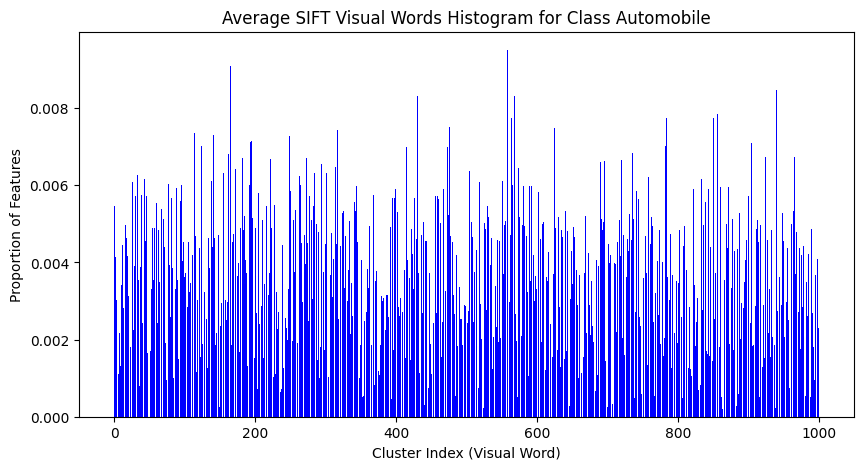

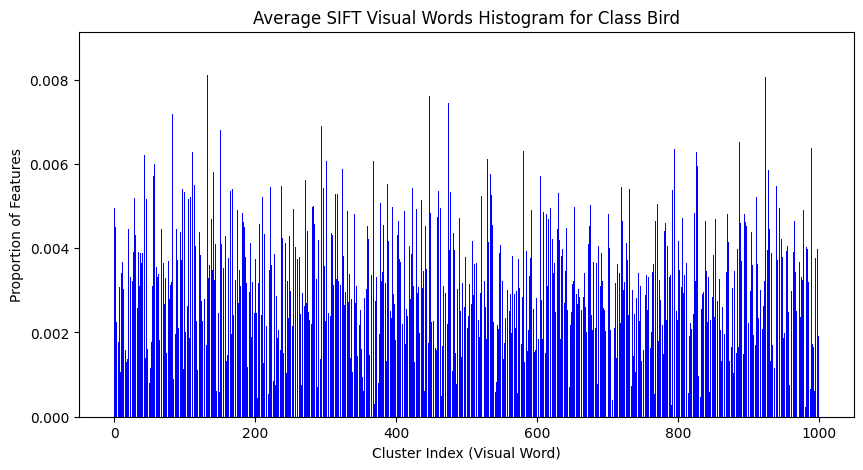

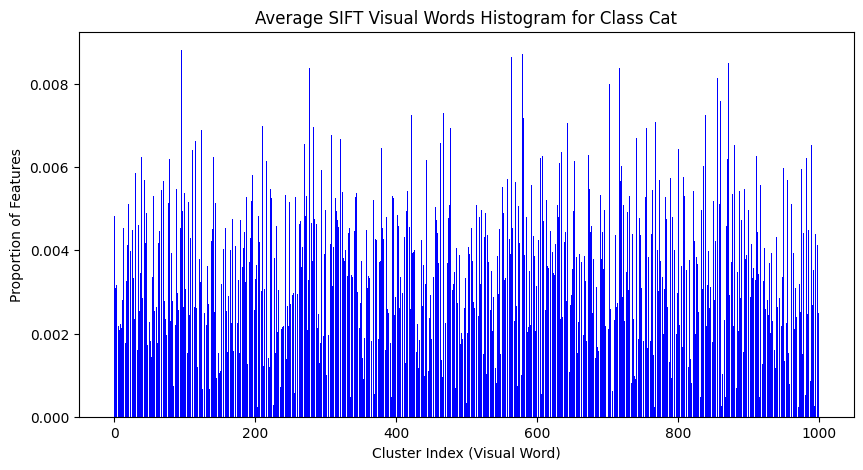

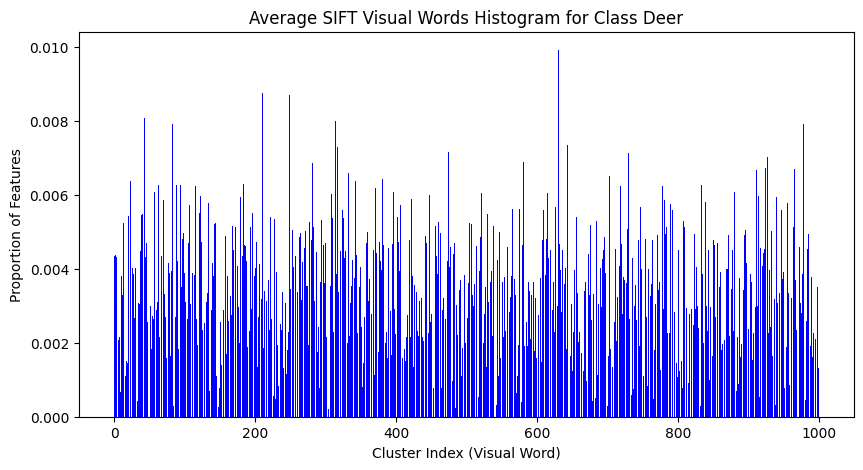

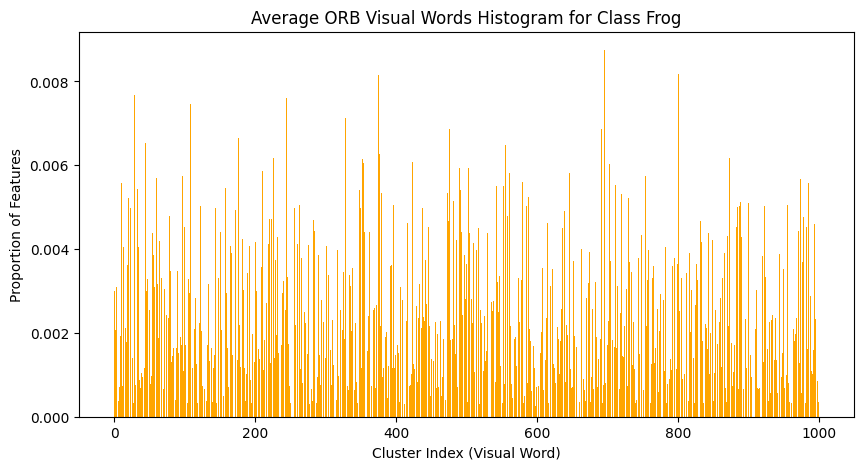

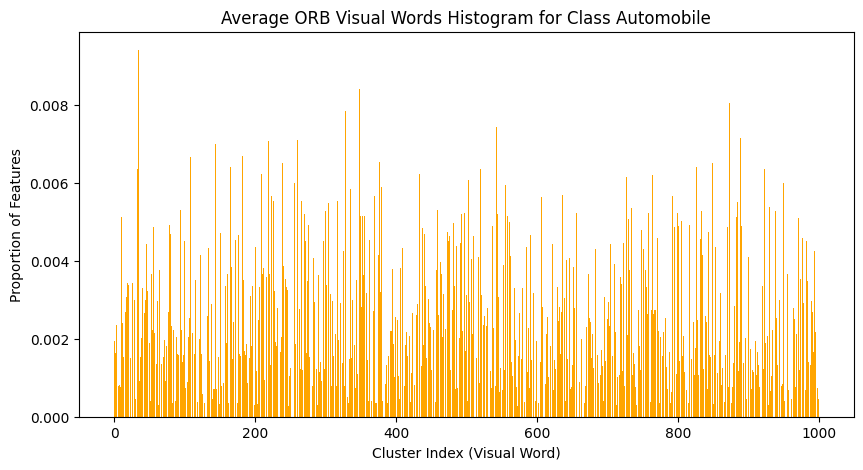

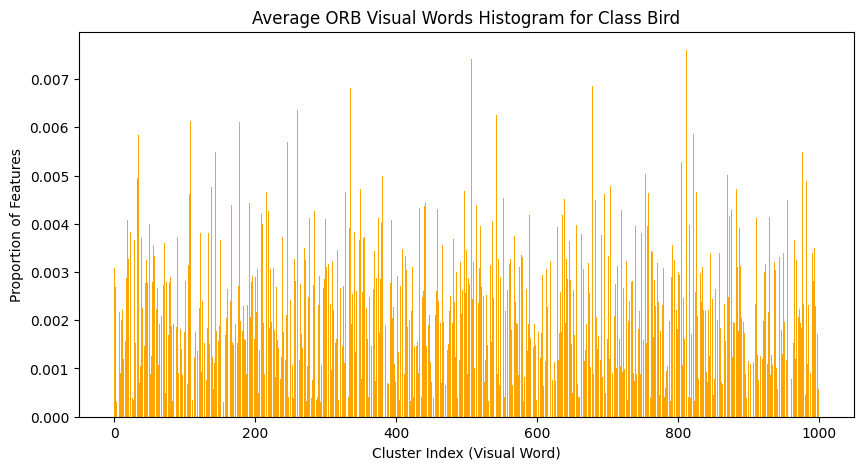

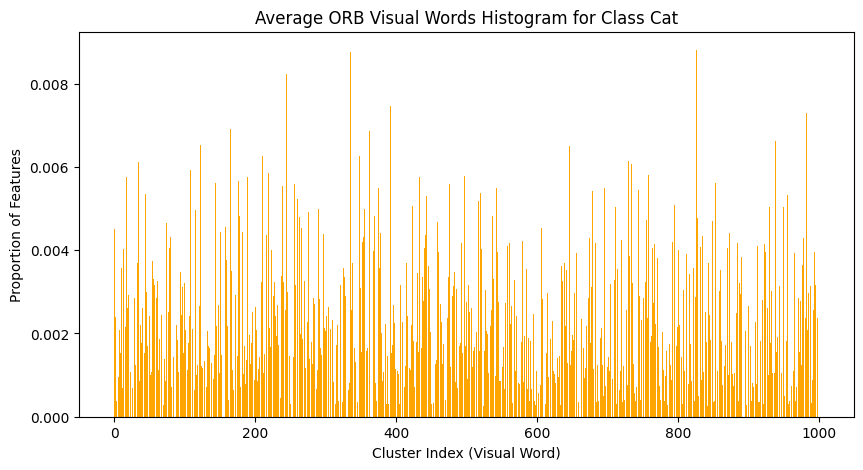

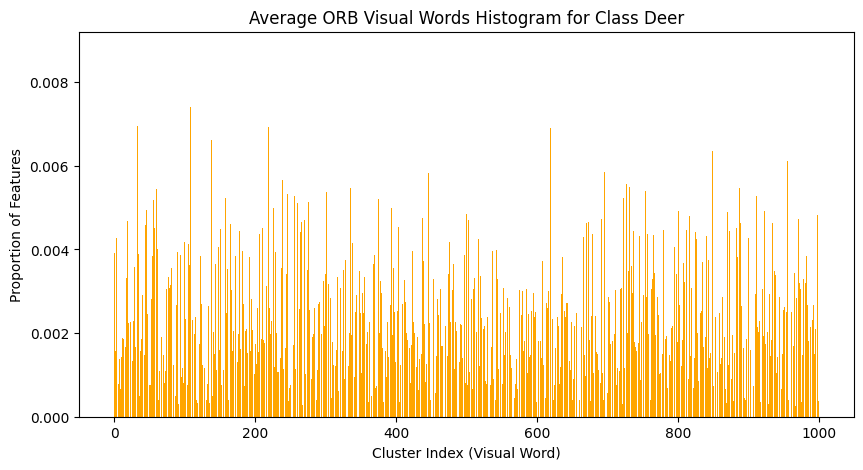

In [10]:
def compute_average_histograms_by_class(images, labels, feature_extractor, num_clusters=1000):
    """
    Compute the average histogram for each class using the visual vocabulary created with KMeans
    :param images: List of images
    :param labels: Corresponding labels for the images
    :param feature_extractor: Feature extractor (e.g., SIFT, ORB)
    :param num_clusters: Number of clusters (default is 1000)
    :return: Dictionary of average histograms for each class
    """
    # Encode image features
    encoded_features = encode_image_features(images, feature_extractor, num_clusters=num_clusters, normalize_histogram=True)

    # Compute average histogram for each class
    unique_labels = np.unique(labels)
    average_histograms = {}

    for label in unique_labels:
        class_indices = np.where(labels == label)[0]
        class_histograms = encoded_features[class_indices]
        average_histogram = np.mean(class_histograms, axis=0)
        average_histograms[label] = average_histogram

    return average_histograms

# Visualize the average histograms for each class
def plot_average_histogram(average_histogram, class_name, feature_type, bar_color='blue'):
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(average_histogram)), average_histogram, color=bar_color)
    plt.title(f'Average {feature_type} Visual Words Histogram for Class {class_name}')
    plt.xlabel('Cluster Index (Visual Word)')
    plt.ylabel('Proportion of Features')
    plt.show()


# Compute average histograms for SIFT
sift_average_histograms = compute_average_histograms_by_class(train_images, train_labels, sift)

# Compute average histograms for ORB
orb_average_histograms = compute_average_histograms_by_class(train_images, train_labels, orb)

# Visualize the average histograms for each class using SIFT
for class_name, average_histogram in zip(label_mapping.values(), sift_average_histograms.values()):
    plot_average_histogram(average_histogram, class_name, 'SIFT')

# Visualize the average histograms for each class using ORB
for class_name, average_histogram in zip(label_mapping.values(), orb_average_histograms.values()):
    plot_average_histogram(average_histogram, class_name, 'ORB', bar_color='orange')

<a id="section-6"></a>
### **Section 6: Encoding Test Image Features (0 points)**

In this section, the task is to encode the test image features using the visual vocabulary created from the training set. Similar to the previous encoding step, each test image will be represented as a histogram of visual words, which will then be used for evaluating classification performance.

Use the same two feature extraction techniques you selected earlier. Extract keypoints and descriptors for the test images, then encode these images using the visual vocabulary. This will allow you to compare the encoded features of test images against those of the training set.

**Hint:** Reuse the functions developed earlier for extracting keypoints, descriptors, and encoding images. Ensure that you use the visual vocabulary constructed with the training images for consistency.

Selected 1000 images out of 1000 for descriptor extraction
Selected 1000 images out of 1000 for descriptor extraction


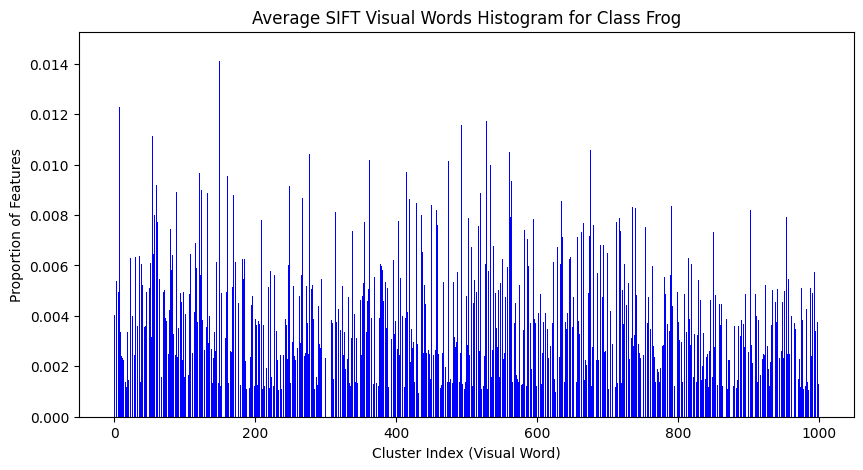

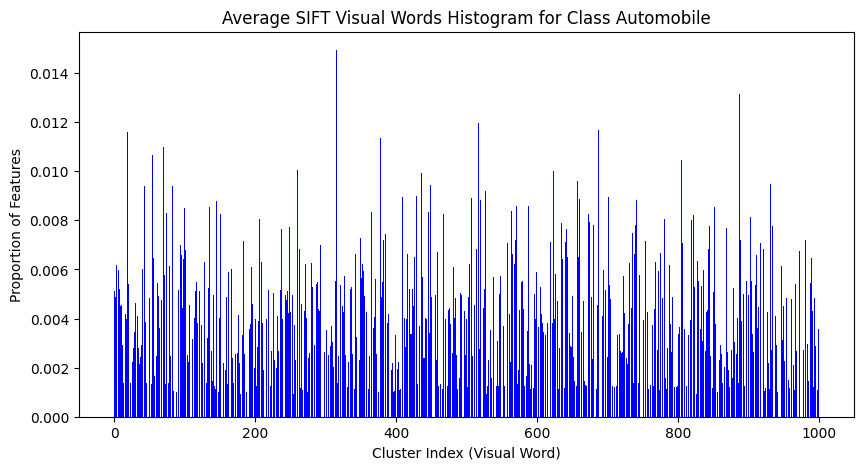

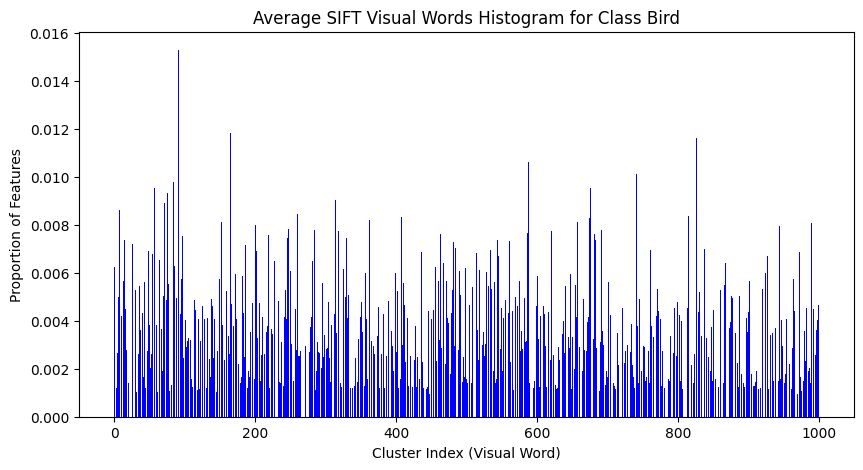

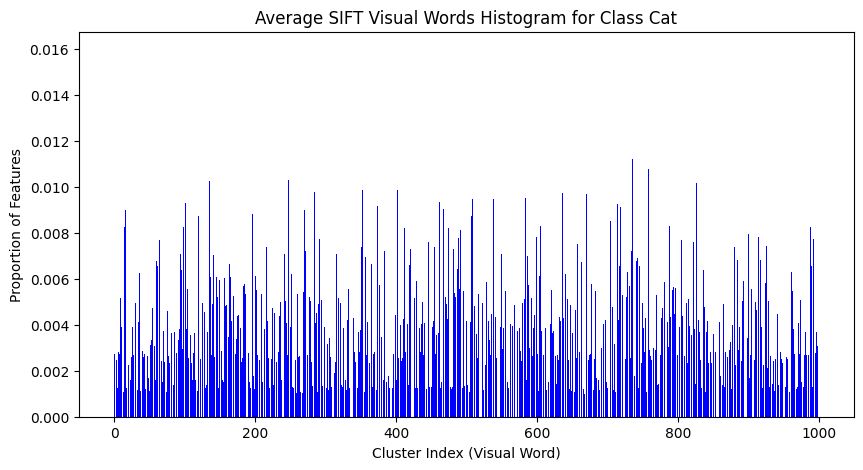

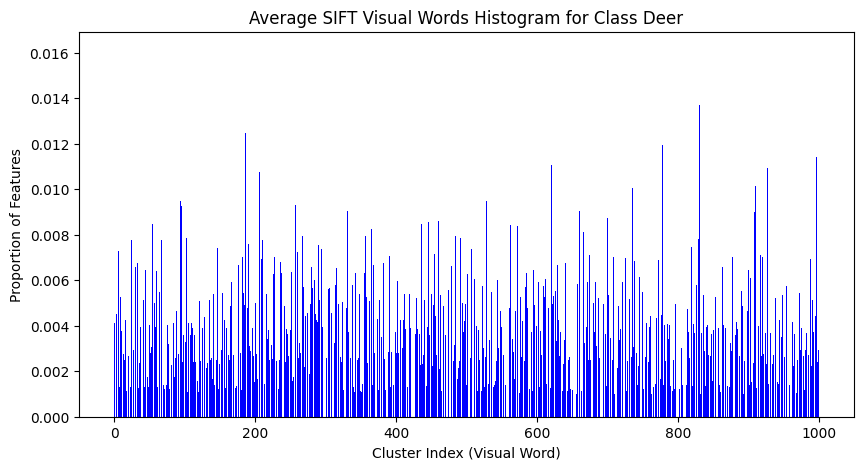

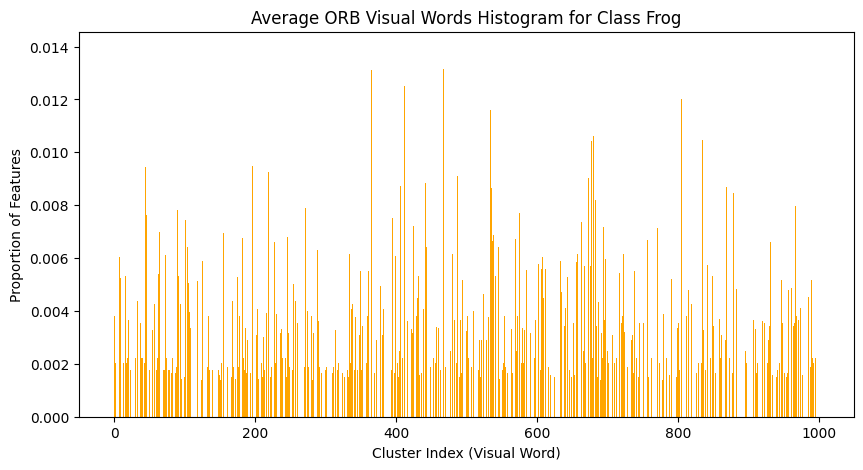

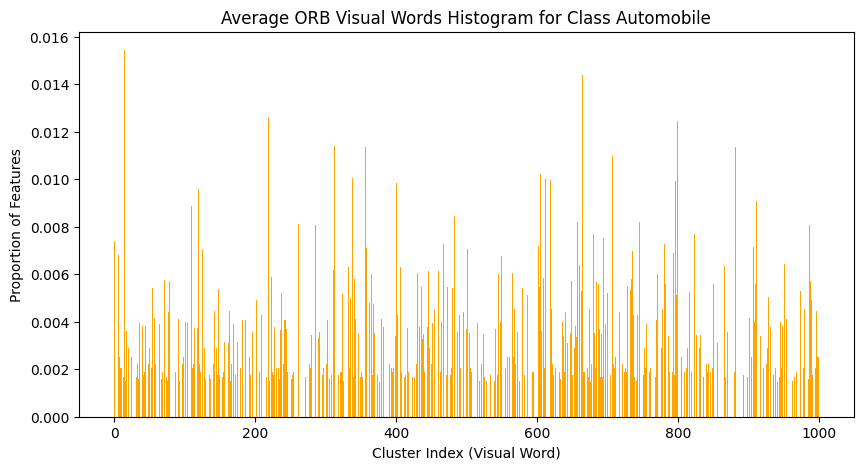

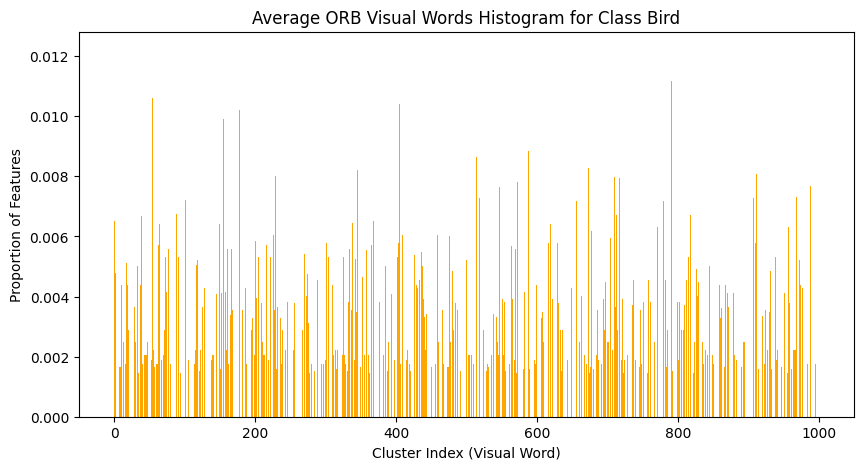

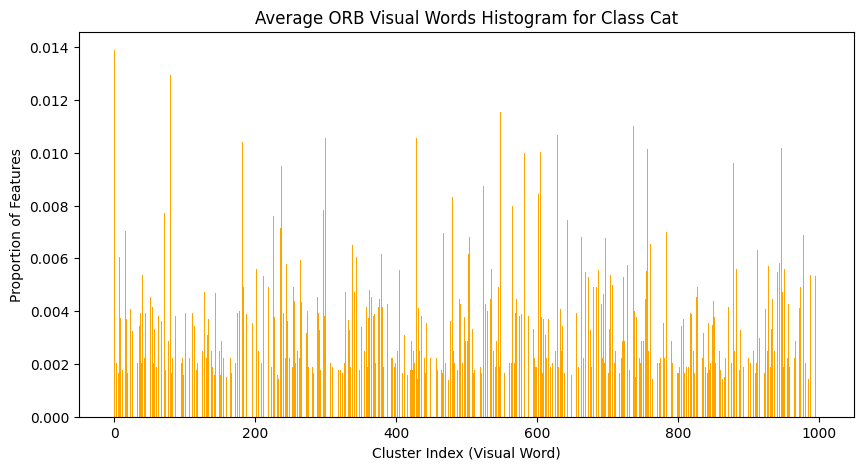

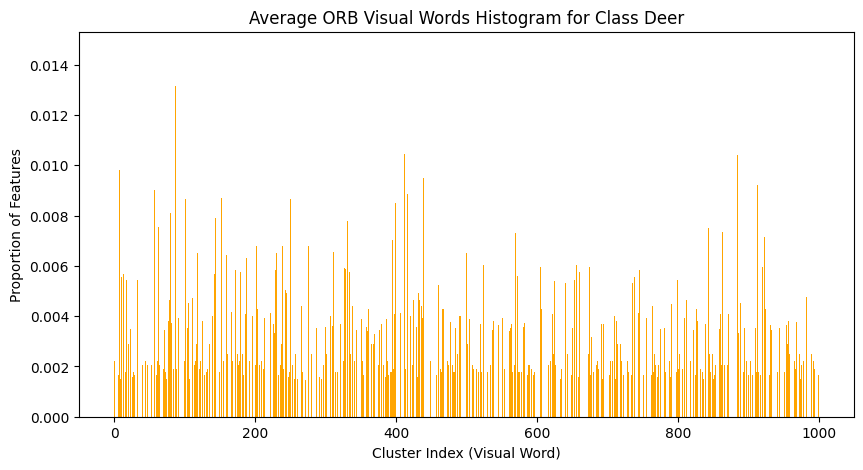

In [11]:
# YOUR CODE HERE
sift_descriptors_test = extract_descriptors(test_images, test_labels, sift, subset_ratio=1)
orb_descriptors_test = extract_descriptors(test_images, test_labels, orb, subset_ratio=1)

# Build visual vocabulary for test set
sift_kmeans_test = build_visual_vocabulary(sift_descriptors_test)
orb_kmeans_test = build_visual_vocabulary(orb_descriptors_test)

# Encode test images using visual vocabulary
sift_encoded_features_test = encode_image_features(test_images, sift, num_clusters=1000)
orb_encoded_features_test = encode_image_features(test_images, orb, num_clusters=1000)

# Compute average histograms for test set
sift_average_histograms_test = compute_average_histograms_by_class(test_images, test_labels, sift)
orb_average_histograms_test = compute_average_histograms_by_class(test_images, test_labels, orb)

# Visualize the average histograms for each class using SIFT
for class_name, average_histogram in zip(label_mapping.values(), sift_average_histograms_test.values()):
    plot_average_histogram(average_histogram, class_name, 'SIFT')

# Visualize the average histograms for each class using ORB
for class_name, average_histogram in zip(label_mapping.values(), orb_average_histograms_test.values()):
    plot_average_histogram(average_histogram, class_name, 'ORB', bar_color='orange')

<a id="section-7"></a>
### **Section 7: Training the Classifiers (5 points)**

In this section, the task is to create two one-vs-rest (OvR) SVM classifiers using the 50% of the training data that was **not** used for creating the visual dictionary. This ensures that the classifiers are trained on a different subset of data, providing a more robust evaluation of the visual vocabulary's effectiveness.

For each of the two selected feature extraction techniques, create one-vs-rest classifiers for all classes. For now, use default parameter values when training the classifiers; you will experiment with different hyperparameters in later steps.

**Note:** Training an OvR classifier can take around 5 to 7 minutes. Therefore, it's advisable to first test your code with a smaller subset of the training data to verify that your implementation works correctly before running it on the full dataset.

In [76]:
# YOUR CODE HERE

<a id="section-8"></a>
### **Section 8: Evaluating the Classifiers (12 points)**

In this section, you will evaluate the performance of your one-vs-rest (OvR) SVM classifiers on the test data. The goal is to classify each test image using each binary classifier and rank the images based on the classification scores, resulting in a ranked list of images for each class. Ideally, images belonging to the target class should appear at the top of the respective list. To conduct this evaluation, use the test image histograms generated earlier for the two selected feature extraction techniques. Classify each test image with each classifier, rank them based on their confidence scores, and then compute the Mean Average Precision (mAP) across all classes. The mAP for a single class $c$ is defined as:

$
\text{mAP}_c = \frac{1}{m_c} \sum_{i=1}^{n} \frac{f_c(x_i)}{i}
$

where:
- $n$ is the total number of images ($n = 50 \times 5 = 250$),
- $m_c$ is the number of images of class $c$ ($m_c = 50$),
- $x_i$ is the $i^{th}$ image in the ranked list $X = \{ x_1, x_2, \dots, x_n \}$,
- $f_c$ is a function that returns the number of images of class $c$ in the first $i$ images if $x_i$ is of class $c$, and 0 otherwise.

For instance, if you are retrieving images of class "R" and the sequence of ranked images is $[R, R, T, R, T, T, R, T]$, then $n = 8$, $m_c = 4$, and:

$
AP = \frac{1}{4} \left( \frac{1}{1} + \frac{2}{2} + \frac{0}{3} + \frac{3}{4} + \frac{0}{5} + \frac{0}{6} + \frac{4}{7} + \frac{0}{8} \right).
$

In addition to the quantitative analysis, perform a qualitative analysis by visualizing the top-5 and bottom-5 ranked test images.

In [77]:
# YOUR CODE HERE

<a id="section-9"></a>
### **Section 9: Hyperparameter Search (16 points)**

In this section, the task is to perform an extensive hyperparameter search to optimize the performance of your classifiers. You will experiment with various parameters, including the number of visual words (e.g., 500, 1000, 1500), different training subset sizes (e.g., 30%, 40%, 50%), SVM parameters (e.g., kernel types like 'linear' or 'rbf', regularization parameter $C$ values such as 0.1, 1, 10, and gamma settings like 'scale' or specific values such as 0.01, 0.001), and settings of the feature extractors (e.g., the number of keypoints or scale levels). Start by testing your code on the smallest subset to ensure it functions correctly before proceeding with a full hyperparameter search. Once validated, conduct the search using larger subsets and systematically iterate through the different parameter combinations, potentially using nested loops or grid search. Be sure to record the performance results for each combination to identify the best settings based on metrics like the Mean Average Precision (mAP).

In [78]:
# YOUR CODE HERE

<a id="section-10"></a>
### **Section 10: Using CLIP for Image Classification (5 points)**

**<span style="color:red">⚠️ NOTE: This section should NOT be included in the report. It is only meant to be completed in the code cells. The purpose of this task is to introduce you to a more state-of-the-art model (CLIP) compared to Bag of Visual Words (BoVW). Vision Transformers (ViT) will be covered in more detail in the Deep Learning 1 course next period!</span>**

In this section, you will use a pre-trained CLIP model for image classification. CLIP (Contrastive Language-Image Pretraining) is a vision-language transformer model trained on a large dataset of images and text. It consists of two main components: a Vision Transformer (ViT) and a text Transformer. The ViT encodes images by dividing them into patches (tokens), flattening each patch into a vector, and passing them through a sequence of Transformer layers to produce an encoded representation of the image.

For this task, you will use the visual transformer component of CLIP to extract encoded representations of the input images. While this is not the typical way to use CLIP (which involves encoding both images and text for similarity comparison), it provides an interesting application of this state-of-the-art model for image classification.

**To Install CLIP:**
```python
pip install git+https://github.com/openai/CLIP.git
```

**Additional Reading (if you're interested):**
- [OpenAI CLIP Overview](https://openai.com/clip)
- [Vision Transformer (ViT) Paper](https://arxiv.org/abs/2010.11929)
- [Tutorial on Vision Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/vision-transformer.html)
- [UvA's Deep Learning Introduction to ViTs](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html)

First, create DataLoaders for both the training and test datasets by filtering the CIFAR-10 dataset to include only the selected classes: frog, automobile, bird, cat, and deer. Use a batch size of 16 for both DataLoaders, and resize the images to 224x224 to match the input size requirements for CLIP. Remember to normalize the images using the appropriate mean and standard deviation. Use a training set size of 1000 images per class and a test set size of 200 images per class.

In [37]:
# YOUR CODE HERE
# Define total train and test sizes
total_train_size = 1000  # Default value for total training images
total_test_size = 200   # Default value for total test images

# Define batch sizes for DataLoader
train_batch_size = 16
test_batch_size = 16

# Number of classes
num_classes = 5

# Compute images per class for training and testing
images_per_class_train = total_train_size // num_classes  # e.g., 5000 // 5 = 1000 per class
images_per_class_test = total_test_size // num_classes    # e.g., 1000 // 5 = 200 per class

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize to 224x224 for CLIP
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std
])

# Define the class indices for the 5 selected classes: frog, automobile, bird, cat, and deer
selected_classes = [6, 1, 2, 3, 4]  # 6: frog, 1: automobile, 2: bird, 3: cat, 4: deer
class_to_label = {orig_class: new_label for new_label, orig_class in enumerate(selected_classes)}

# Function to filter and remap dataset
def filter_dataset(dataset, images_per_class, selected_classes, class_to_label):
    selected_indices = []
    class_counts = {class_idx: 0 for class_idx in selected_classes}
    remapped_labels = []

    for idx, (image, label) in enumerate(dataset):
        if label in selected_classes and class_counts[label] < images_per_class:
            selected_indices.append(idx)
            remapped_labels.append(class_to_label[label])
            class_counts[label] += 1

            # Stop if we have enough samples for each class
            if all(count >= images_per_class for count in class_counts.values()):
                break

    filtered_dataset = Subset(dataset, selected_indices)
    return filtered_dataset, remapped_labels

# Load the CIFAR-10 training set
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter and remap training set
filtered_train_set, train_mapped_labels = filter_dataset(train_set, images_per_class_train, selected_classes, class_to_label)

# Load the CIFAR-10 test set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter and remap test set
filtered_test_set, test_mapped_labels = filter_dataset(test_set, images_per_class_test, selected_classes, class_to_label)

# Create data loaders for the filtered datasets
train_data_loader = DataLoader(filtered_train_set, batch_size=train_batch_size, shuffle=False)
test_data_loader = DataLoader(filtered_test_set, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Next, we load a pre-trained CLIP model, which is a vision-language transformer designed to predict the text that describes an image and vice versa. The model consists of two components: a Vision Transformer (ViT) for encoding images and a text Transformer for encoding text. 

In [38]:
import clip

# Setup the model and the preprocessor
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the pre-trained CLIP model
model, preprocess = clip.load("ViT-B/32", device=device)

To extract the visual tokens using the CLIP model, start by initializing two empty lists: one for storing the image features and another for the labels. Use `tqdm` to create a progress bar that tracks the extraction process over the DataLoader. Iterate through the DataLoader, extracting images and labels. Disable gradient computation, and then encode the images with `model.encode_image(images)`. Append the encoded features and labels to their respective lists. Remember, the output from the model will have the shape `(batch_size, 512)` due to batched processing, if your are using a single you should reshape the output to `(512,)` to remove the batch dimension.

In this example, we will use the class token as the visual representation of the image. The class token is a 512-dimensional vector that represents the image. We will use this vector to train a classifier to classify the images.

**Note:** The CLIP model is quite large and may take some time to extract features from the images. You can use the `tqdm` library to create a progress bar that shows the extraction progress. It is recommended to test the code with a smaller subset of images to ensure it functions correctly before running it on the full dataset. With the default batch size of 16 and a training set size of 1000 images, the extraction process may take a 10-20 minutes.

In [39]:
from tqdm import tqdm

In [40]:
# YOUR CODE HERE

def extract_tokens(dataloader):
    # initialize lists for: image features, target labels
    image_features_list = []
    target_labels_list = []
    
    # iterate over the dataloader
    for images, labels in tqdm(dataloader, desc="Extracting Tokens"):
        
        # disable gradient computation
        with torch.no_grad():
            
            # encode the images
            image_features = model.encode_image(images.to(device))
            # print("Image features shape:", image_features.shape)
            
            # reshape the output to remove the batch dimension if batch == 1
            if image_features.shape[0] == 1:
                image_features = image_features.squeeze(0)
                # print("Reshaped Image features shape:", image_features.shape)
            
            # append the image features and labels to the respective lists
            image_features_list.append(image_features)
            target_labels_list.append(labels)
            
    return image_features_list, target_labels_list


In [41]:
# Stack the (batched) visual tokens extracted from the images. The resulting shape will be (number_of_images, 512).
image_features_list_train, target_labels_list_train = extract_tokens(train_data_loader) 
print(len(image_features_list_train), len(target_labels_list_train))
stacked_image_features_train = torch.cat(image_features_list_train)
stacked_target_labels_train = torch.cat(target_labels_list_train)

Extracting Tokens: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]

63 63


In [42]:
print(stacked_image_features_train.shape, stacked_target_labels_train.shape)

torch.Size([1000, 512]) torch.Size([1000])


To train a classifier using the visual tokens, start by initializing an SVM classifier using `SVC()` from `scikit-learn`. You can play around with different hyperparameters such as kernel type, regularization parameter, and gamma to find the best configuration. Finally, use the `fit` method to train the classifier on the visual image features and labels.

In [43]:
from sklearn.svm import SVC

In [44]:
# YOUR CODE HERE

# initialize SVM classifier 
classifier = SVC(kernel='linear', C=1.0, gamma='scale')

# train the classifier
classifier.fit(stacked_image_features_train.cpu().numpy(), stacked_target_labels_train.cpu().numpy())

SVC(kernel='linear')

To evaluate the classifier, start by extracting the visual tokens from the test images using the same method applied to the training set. Loop through the test DataLoader, encode each batch of images using the model (e.g., `model.encode_image(images)`), and store the results in separate lists for the features and labels. After extracting all the features, stack them into a single tensor for both the features and labels. This process will prepare the test data for use in evaluating the classifier's performance.

In [45]:
# YOUR CODE HERE
# Extract visual tokens from the test images using same method as training set
image_features_list_test, target_labels_list_test = extract_tokens(test_data_loader)

# Stack the visual tokens extracted from the test images
stacked_image_features_test = torch.cat(image_features_list_test)
stacked_target_labels_test = torch.cat(target_labels_list_test)

Extracting Tokens: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]


To evaluate the performance of your classifier, use the test set features you extracted earlier. First, generate predictions for the test set by passing the stacked test features into your trained classifier's `predict` method. Next, use the `classification_report` function from `sklearn.metrics` to create a detailed report that includes metrics such as precision, recall, and F1-score for each class. Finally, print the report to analyze how well your classifier performs across the different classes.

In [46]:
from sklearn.metrics import classification_report

In [47]:
# YOUR CODE HERE
# generate predictions for the test set
preds = classifier.predict(stacked_image_features_test.cpu().numpy())

# create classification report
report = classification_report(stacked_target_labels_test.cpu().numpy(), preds)
print(report)

              precision    recall  f1-score   support

           1       1.00      0.97      0.99        40
           2       0.78      0.80      0.79        40
           3       0.88      0.90      0.89        40
           4       0.95      0.88      0.91        40
           6       0.81      0.85      0.83        40

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200


<a id="section-x"></a>
### **Section X: Individual Contribution Report *(Mandatory)***

Because we want each student to contribute fairly to the submitted work, we ask you to fill out the textcells below. Write down your contribution to each of the assignment components in percentages. Naturally, percentages for one particular component should add up to 100% (e.g. 30% - 30% - 40%). No further explanation has to be given.

| Name | Contribution on Research | Contribution on Programming | Contribution on Writing |
| -------- | ------- | ------- | ------- |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |
|  | - % | - % | - % |

### - End of Notebook -